<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 444 (delta 117), reused 81 (delta 78), pack-reused 242
Receiving objects: 100% (444/444), 70.48 MiB | 21.60 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=30522 sha256=bb517f5f79af2d33a697c343e44fff5be2fe92e78888e5a61d0b5b34c5bfe758
  Stored in directory: /tmp/pip-ephem-wheel-cache-iz2p47n8/wheels/55/59/29/0fb1c6356521

In [2]:
from dul_2021.utils.hw11_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!pip install einops

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

## Encoder

In [5]:
class ConvReluBN(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=(3, 3), stride=2, padding=1):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(in_features, out_features, kernel_size, stride, padding),
                              nn.BatchNorm2d(out_features),
                              nn.ReLU())

  def forward(self, x):
    return self.conv(x)

In [6]:
class Encoder(nn.Module):
  def __init__(self, lat_dim=128):
    super().__init__()
    self.conv = nn.Sequential(ConvReluBN(3, 32, stride=1),
                              ConvReluBN(32, 64),
                              ConvReluBN(64, 128),
                              ConvReluBN(128, 128),
                              ConvReluBN(128, 64),
                              nn.AdaptiveAvgPool2d(1))
    
    self.lin = nn.Sequential(nn.Flatten(),
                             nn.Linear(64, 256),
                             nn.ReLU(),
                             nn.Linear(256, lat_dim))

  def forward(self, x):
    x = self.conv(x)
    return self.lin(x)

## SwAV

In [25]:
from collections import deque
from itertools import chain
import einops
from torch.optim import Adam
import torch.nn.functional as F

class SwAV:
  def __init__(self, temperature, max_len, num_of_classes, lat_dim=128):
    self.l_dim = lat_dim
    self.cl_num = num_of_classes
    self.temp = 1 / temperature

    self.encoder = Encoder(lat_dim).to(device)
    self.C = nn.Parameter(torch.randn((lat_dim, num_of_classes), device=device))
    self.opt = Adam([*self.encoder.parameters(), self.C], 1e-4)
    self.features = deque(maxlen=max_len)
 
    # Transformation for big crops (32 x 32)
    self.simple_crop = transforms.Compose([transforms.RandomHorizontalFlip(),
                                           transforms.RandomResizedCrop(size=32, scale=(0.5, 1.0)),
                                           transforms.Normalize((-1,), (2.0,)),
                                           transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                                           transforms.Normalize((0.5,), (0.5,))])
    
    # Transformation for small crops (16 x 16)
    self.mini_crop = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomResizedCrop(size=16, scale=(0.4, 0.5)),
                                         transforms.Normalize((-1,), (2.0,)),
                                         transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                                         transforms.Normalize((0.5,), (0.5,))])

  def transforms(self, x):
    normal = torch.cat([self.simple_crop(x) for _ in range(2)], dim=0)
    mini = torch.cat([self.mini_crop(x) for _ in range(3)], dim=0)
    return normal, mini

  def sinkhorn_knopp(self, score, ε_inv=20, n_iters=3):
    Q = torch.exp(ε_inv * score)
    for _ in range(n_iters):
      Q = F.normalize(Q, dim=1, p=1.0) / score.shape[1]
      Q = F.normalize(Q, dim=0, p=1.0) / score.shape[0]
    return F.normalize(Q, dim=1, p=1.0)

  def update(self, z):
    # Normalize centroids and features
    z = F.normalize(z, dim=2)
    self.C.data = F.normalize(self.C.data, dim=0)

    # Take features of big crops
    x = z[:, :2].reshape(-1, self.l_dim)
    
    # Compute codes using only big crops (and features from previous iterations)
    with torch.no_grad():
      q_list = []
      for j in range(2):
        score_q = torch.matmul(torch.cat([x[j::2], *self.features], dim=0), self.C)
        q = self.sinkhorn_knopp(score_q).unsqueeze(0)
        q_list.append(q)
      Q = torch.cat(q_list, dim=0)

    # swap loss
    score_z = self.temp * torch.matmul(z, self.C)
    loss = 0
    for j in range(2):
      log_sf = F.log_softmax(torch.cat([score_z[:, :j], score_z[:, j+1:]], dim=1), dim=2)
      q = Q[j, :z.shape[0]].unsqueeze(1)
      q = q.expand(-1, 4, -1)
      loss -= (log_sf * q).mean(dim=(0, 1))
    
    # Reduction
    loss = loss.sum()

    self.opt.zero_grad()
    loss.backward()
    self.opt.step()

    # Append computed features to buffer 
    self.features.appendleft(x)

    return loss.item()

## Hyperparameters

In [32]:
batch_size = 128
n_epochs = 10

lat_dim = 128
temperature = .1
num_of_centroids = 128
buf_size = 5

In [33]:
from torch.utils.data import DataLoader

train_cifar, _ = get_data('CIFAR10')
train_data = DataLoader(train_cifar, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Define model

In [34]:
model = SwAV(temperature, buf_size, num_of_centroids, lat_dim)

# Initialize feature buffer
for (x, _), _ in zip(train_data, range(buf_size)):
  t, _ = model.transforms(x.to(device))
  with torch.no_grad():
    z = model.encoder(t)
    z = einops.rearrange(z, '(v b) l -> (b v) l', v=2)
    z = F.normalize(z, dim=1)
  model.features.appendleft(z)

## Train loop

In [29]:
loss_record = []

for epoch in range(n_epochs):
  for x, _ in train_data:
    t_normal, t_mini = model.transforms(x.to(device))

    z_normal = model.encoder(t_normal)
    z_normal = einops.rearrange(z_normal, '(v b) l -> b v l', v=2)

    z_mini = model.encoder(t_mini)
    z_mini = einops.rearrange(z_mini, '(v b) l -> b v l', v=3)

    z = torch.cat([z_normal, z_mini], dim=1)

    loss = model.update(z)
    loss_record.append(loss)

  print(f"EPOCH: {epoch}")
  print(f"\t loss : {sum(loss_record[-50:]):.5f}")

EPOCH: 0
	 loss : 381.01787
EPOCH: 1
	 loss : 346.47738
EPOCH: 2
	 loss : 326.51877
EPOCH: 3
	 loss : 311.75457
EPOCH: 4
	 loss : 299.17268
EPOCH: 5
	 loss : 287.05946
EPOCH: 6
	 loss : 279.69062
EPOCH: 7
	 loss : 274.80334
EPOCH: 8
	 loss : 268.49274
EPOCH: 9
	 loss : 259.21014


## Results

In [30]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    model.encoder.eval()
    enc = model.encoder.to("cpu")
    return np.array(loss_record), lambda t: F.normalize(enc(t), dim=1)

Files already downloaded and verified
Files already downloaded and verified
mean classification accuracy=0.4414


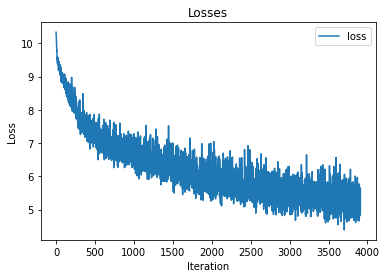

In [31]:
q2_results(b, True)